## Planet Basemap downloader

A notebok

In [1]:
import os
import click
import yaml
import geopandas as gpd
from shapely.geometry import box
from planet.api import ClientV1, auth, utils


import cloudtools as ct
import re
import urllib
import subprocess

from boto3.s3.transfer import S3Transfer, TransferConfig

## Paths and arguments

In [24]:
# local paths
config_path = '/home/rstudio/projects/nmeo/materials/code/' +\
              'yaml/planet_downloader_config-active.yml'

with open(config_path, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)


# s3 arguments
tos3 = 'direct'  # possible values ['direct', 'indirect', 'no']
remove_local = True

### Setup directories

In [7]:
# Create dirs
if not os.path.exists(config['imagery']['quads_path']):
    os.mkdir(config['imagery']['quads_path'])

if not os.path.exists(config['imagery']['tile_path']):
    os.mkdir(config['imagery']['tile_path'])


## Functions

In [15]:
def list_s3_images(bucket, prefix, date, suffix='.tif'):
    """Check AWS bucket to get list of images, to check against to avoid 
    unnecessary requests
    
    Parameters:
    ----------
    bucket : str
        Name of S3 bucket to transfer to 
    prefer : str
        Prefix of folder in S3 bucket to transfer into
    date : 
        Date of basemap tiles ('YYYY-MM' format) to check for in bucket
        
    Returns:
    -------
    A list of keys
    
    """
    s3resource = ct.aws_resource('s3', profile=None)
    keys = ct.list_objects(s3resource, bucket = bucket, prefix = prefix, 
                           suffix = '.tif')
    
    if isinstance(date, list):
        if len(date) > 1:
            pattern = '|'.join(date)
        else:
            pattern = date[0]
    elif isinstance(date, str):
        pattern = date
    
    image_list = [key for key in keys if re.search(r'{}'.format(pattern), key)]
    
    return(image_list)


## Get configurations and create Planet Client

In [9]:
# Initial Planet client
if auth.find_api_key() is None:
    utils.write_planet_json({'key': config['planet']['key']})
client = ClientV1()

### Load study area

In [10]:
aoi = gpd.read_file(config['imagery']['geom'])[['geometry']].dissolve()
bbox = aoi.total_bounds

### Create grid of tiles to download

The ordering filter uses a bbox, so a query is to get a list of quads intersecting the bounding box of the geometry of our `aoi` (loaded above)

In [11]:
# Because the tiles are the same, so just use the first date to get tiles
mosaic = client.get_mosaics(name_contains=config['imagery']['dates'][0]).get()['mosaics'][0]
quads = client.get_quads(mosaic, bbox=bbox).items_iter(limit=10000)
tiles = []
ids = []
for quad in quads:
    tiles.append(box(quad['bbox'][0], quad['bbox'][1],
                     quad['bbox'][2], quad['bbox'][3]))
    ids.append(quad['id'])

A spatial inner join is done between the input `aoi` and the geometries of the quads the intersecting the bounding box of the `aoi`, thereby dropping the quads that don't intersect the `aoi`.  

In [12]:
tiles = gpd.GeoDataFrame({'tile': ids, 'geometry': tiles}, crs="EPSG:4326")
# tiles = gpd.overlay(aoi, tiles)
tiles = gpd.sjoin(left_df=tiles, right_df=aoi).drop(columns=['index_right'])
file = os.path.join(
    config['imagery']['tile_path'], 
    '{}_tiles_nicfi.geojson'.format(config['imagery']['tile_path']))
tiles.to_file(file, driver='GeoJSON')

<AxesSubplot:>

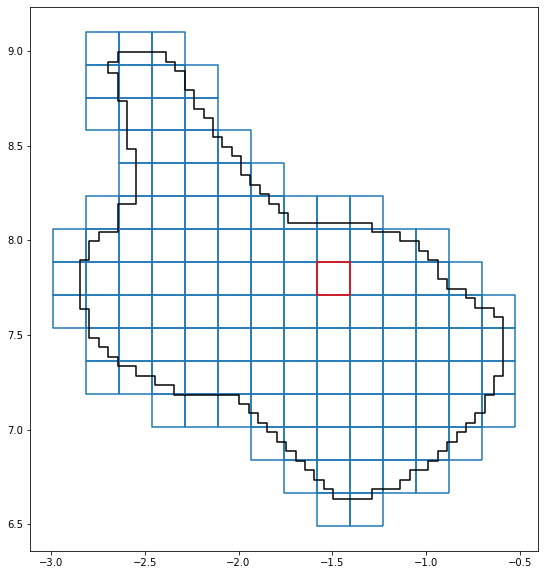

In [23]:
tiles_ss = tiles.iloc[[49]]
# tiles
# tiles.boundary.plot()

ax1 = tiles.boundary.plot(figsize=(25,10))
aoi.boundary.plot(ax = ax1, color='black')
tiles_ss.boundary.plot(ax = ax1, color='red')

### Get list of images on bucket

If an S3 transfer option is selected

In [25]:
if tos3 in ['direct', 'indirect']:
    
    bucket = config['s3']['bucket']
    prefix = config['s3']['prefix']
    
    # S3 credentials
    s3client = ct.aws_client('s3', profile=None)
    # print(tos3)
    image_list = list_s3_images(bucket, prefix, config['imagery']['dates'])
    
    if tos3 == 'indirect':
        s3transfer = S3Transfer(s3client)

In [26]:
# Download quads, and filter by the tiles
for nm_contain in config['imagery']['dates']:
    mosaic = client.get_mosaics(name_contains=nm_contain).get()['mosaics'][0]
    quads = client.get_quads(mosaic, bbox=bbox).items_iter(limit=10000)
    for quad in quads:
        #if quad['id'] in list(tiles['tile']):
        if quad['id'] in list(tiles_ss['tile']):
            
            # file name
            fname = mosaic['name'] + '_' + quad['id'] + '.tif'
            
            # get image if not already on s3
            if tos3 in ['direct', 'indirect']:
                s3_key = os.path.join(prefix, fname)
                
                if s3_key not in image_list:
                    # direct transfer option
                    if tos3 == 'direct':
                        print('Direct cloud transfer')
                        
                        download_url = quad['_links']['download']
                        with urllib.request.urlopen(download_url) as response:
                            s3client.put_object(
                                Body = response.read(), Bucket = bucket, 
                                Key = s3_key
                            )
                        print('{} transferred directly'.format(s3_key))
                            
                    # indirect option--first to local then upload (might be more robust)
                    elif tos3 == 'indirect':
                        print('Indirect transfer to S3'.format(file))

                        file = os.path.join(config['imagery']['quads_path'], 
                                            fname)
                        if not os.path.exists(file):
                            client.download_quad(quad).get_body().write(file)
                        else:
                            print('File {} already exists, uploading to S3'.\
                                  format(file))
                            
                        # Upload to S3
                        s3transfer.upload_file(file, bucket, s3_key)
                        print('File {} uploaded to S3'.format(file))
                        
                        if remove_local:
                            os.remove(file)
                            print('Removed file {}'.format(file))
                            
                else: 
                    print('{} is aleady on S3'.format(s3_key))
            
            # local transfer only
            else: 
                print('Local download only'.format(file))
                
                file = os.path.join(config['imagery']['quads_path'], fname)

                if not os.path.exists(file):
                    client.download_quad(quad).get_body().write(file)
                else:
                    print('File {} already exists locally'.format(file))         

Direct cloud transfer
g387_testuser/nicfi/planet_medres_normalized_analytic_2021-11_mosaic_1015-1068.tif transferred directly
Direct cloud transfer
g387_testuser/nicfi/planet_medres_normalized_analytic_2021-12_mosaic_1015-1068.tif transferred directly
